Rayleigh Taylor instability
======

Benchmark tests taken from van Keken *et al.* 1997
------------

This example introduces the concepts:
1. swarms of particles
2. mapping different materials
3. conditional functions (in built in underworld)
4. producing snapshot images to file (which can then be made into a movie)

References
-----

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import glucifer.pylab as gplt # plt gets clobbered by matplotlib (used below)
import numpy as np

Set physical values for test case, specifically the simulation resolution (*res*) and number of dimensions (*dim*). 

In [2]:
res = 64
dim = 2
Box_Length = 0.9142
Box_Height = 1.0
BoxSize = (Box_Length, Box_Height)

Here we also set the viscosity of the light material ($\eta \leq$ 1) relative to the reference heavy material ($\eta_r = 1$) which is used when we set up the parameters and functions below. This is set to be $\eta =$ 1, 0.1 and 0.01 for the 3 cases given in van Keken *et al.* 1997.

In [3]:
eta = 1.0

Set input and output file directory paths. Input files are previous $v_{rms}$ and $Nu$ numbers as a function of time. The output path directory will contain the resulting $v_{rms}$ and $Nu$ data as well as the image snap shots.

In [4]:
inputPath = 'RTInput/'
outputPath = 'RTOutput/'

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [5]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(res,res), 
                                           minCoord=(0.,0.), 
                                           maxCoord=BoxSize)
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

2


Create Finite Element (FE) variables for the velocity and pressure fields. The velocity field contains a vector of *dim* dimensions at each mesh point, while the pressure needs only a single value as it is a scalar field.

In [6]:
velocityField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )

Set initial conditions and values for boundary conditions
------

In [7]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Set Dirichlet boundary conditions
------

Use the Dirichlet condition function to flag the boundary vertices (set in IWalls and JWalls) that the system will consider as fixed boundary conditions.

In [8]:
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
AllWalls = IWalls + JWalls

freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(AllWalls,JWalls) )

Create a particle swarm
=====

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

Underworld uses these when the local fluid density is calculated on the mesh, which in turn affects the fluid velocity, and subsequently the advection of the particle swarm.

Setup a swarm
-----

To set up a swarm of particles the following steps are needed:
1. initialise and name a swarm, here called gSwarm (g for global)
2. define data variable to store an index that will state what material a given particle is
3. populate the swarm over the whole domain using the layout command, here this is used to allocate 20 particles in each grid cell
4. indicate to underworld that this swarm of particles is active

In [9]:
# initialise a swarm
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# create a layout object that will populate the swarm across the whole domain
gLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20 )

# activate the layout object
gSwarm.populate_using_layout( layout=gLayout )

Allocate materials to particles
------

Each particle in the swarm can be given individual values, such as viscosity and density. The concept of materials is used in underworld to simplify this process and not have to set these quantities for each particle by hand.

Instead groups of particles can be defined to be a single material and the material can be defined to have particular physical values and behaviours.

The example below sets particles of the swarm to be one of two materials based on the initial particle position in the system. Later these materials are given specific densities and viscosities.

In [10]:
# initialise the 'materialVariable' data to represent two different materials. 
materialHeavyIndex = 0
materialLightIndex = 1

# the form of this perturbation is taken from van Keken et al. 1997
wavelength = 2.0*Box_Length
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength
coordinate = fn.input()
perturbationFn = offset + amplitude*fn.math.cos( k*coordinate[0])
materialVariable.data[:] = fn.branching.conditional( 
    [ ( perturbationFn > coordinate[1] , materialLightIndex ),
    (                             True , materialHeavyIndex )  ] 
    ).evaluate(gSwarm)

The materials are set using a underworld function called 'branching.conditional' which has the form of:

    if( [ (condition function 1, action function 1), 
          (condition function 2, action function 2), 
          ... ] )

which begins at the first function and if it is true it preforms the action, if it is not true then the next conditional function is tested and so on. If no condition functions return true then the function will return an error.

This particular example will classify all points which satisfy
\\[
0.2 + \cos \left( \frac{2 \pi x}{\lambda} \right) > z
\\]
to have the light material index. Here the notation is adopted of $z$ for coordinate[1], $x$ for coordinate[0] and $\lambda$ for the wavelength. If this condition is not satisfied then the particle will be labelled by the heavy index, as this condition is always true.

For more examples of setting up shapes using swarms see **Swarms.ipynb**


Plot the initial positions for the particle swarm
====

Setup a standard method for plotting all particles in a swarm with colour set by the material index (light or heavy).

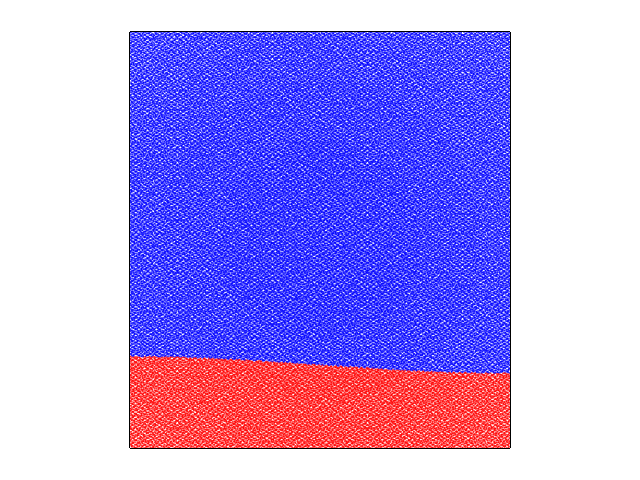

In [11]:
fig1 = gplt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable, pointSize=3, colours='blue red', colourBar = False)
fig1.show()

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

The Map function allows us to create 'per material' type behaviour. Again we use the branching function to set up a (condition, action) command, which in this case uses uses the materialVariable to distinguish which value to use for the density or viscosity for each swarm particle.


In [12]:
# Here we set a density of '0.' for the lightMaterial, and '1.' for the heavymaterial.
densityFn      = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = { materialLightIndex:0., materialHeavyIndex:1. } )

# Here we set a viscosity value of '1.' for both materials 
viscosityMapFn = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = { materialLightIndex:eta, materialHeavyIndex:1. } )

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = z_hat*densityFn

Setup a Stokes system
======

In this system the velocity field, pressure, viscosity and buoyancy forces need to be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the freeslip boundary conditions for the velocity field.

Note that there is an additional field regarding the swarm. This sets up the swarm for a PIC style integration. For a Gauss integration we simply remove the swarm from the Stokes system. When calculating quantities on the mesh the nearest neighbour particles are used.

This system is solved after each time step using the .solve function (see main loop below).

In [13]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              swarm=gSwarm, 
                              conditions=[freeslipBC,],
                              viscosityFn=viscosityMapFn, 
                              bodyForceFn=buoyancyFn )

Create a swarm advective-diffusive system
=====

Setup the system in underworld by flagging the velocity field variable which will advect the particles in the swarm around the box. We also specify the order of integration for solving the equations, in this case second order integration.

In [14]:
advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2 )

Also create some integral objects which are used to calculate statistics.

In [15]:
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=vdotv )
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.


In [16]:
# Stepping. Initialise time and timestep.
time = 0.
steps = 0
time_end = 300
steps_output = 20
timevals = []
vrmsvals = []

Set up image output to file after every time step. This will output a png file with the step number to the directory specified in the outputPath variable. These files can be stitched together into an animation. An example of this is using the terminal command:

    convert -delay 5 -loop 0 image*.png animation.gif

A comparison animation is included in the input path directory.

Firstly the figure style is setup (below). Secondly the figure is saved with updated swarm particle positions at the end of each time iteration using the figSnapshot.savefig command.

In [17]:
figSnapshot = gplt.Figure()
figSnapshot.Points( swarm=gSwarm, colourVariable=materialVariable, pointSize=3, colours='blue red', colourBar = False)

Run time loop until $v_{rms}$ is expected to settle; t = 2000 taken from van Keken *et al.* 1997.

In [18]:
while time<time_end:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size
    advector.integrate(dt)
    # Calculate the RMS velocity
    v2sum = v2sum_integral.integrate()
    volume = volume_integral.integrate()
    vrms = math.sqrt(v2sum[0]/volume[0])
    vrmsvals.append(vrms)
    timevals.append(time)
    if steps%steps_output == 0:
        print 'step =',steps, 'time =', time, 'vrms = ', vrms
    # output figure to file
    figSnapshot.save_image(outputPath+"image"+str(steps).zfill(4))
    # Increment
    time += dt
    steps += 1
print 'step =',steps, 'time =', time, 'vrms = ', vrms

step = 0 time = 0.0 vrms =  0.00018493383262
step = 20 time = 137.084587785 vrms =  0.00101937574684
step = 40 time = 170.291892513 vrms =  0.00188820397585
step = 60 time = 190.337799482 vrms =  0.00259014643429
step = 80 time = 206.461611502 vrms =  0.00301603795904
step = 100 time = 221.354076816 vrms =  0.00312276780047
step = 120 time = 236.500613074 vrms =  0.00295232836835
step = 140 time = 253.179663701 vrms =  0.00257932217277
step = 160 time = 272.656836555 vrms =  0.00216026643511
step = 180 time = 295.953488853 vrms =  0.00179319052653
step = 184 time = 301.129464552 vrms =  0.00174418472088


Plot final swarm positions
=====

Use the same plotting function defined above to plot the current positions of the swarm particles.

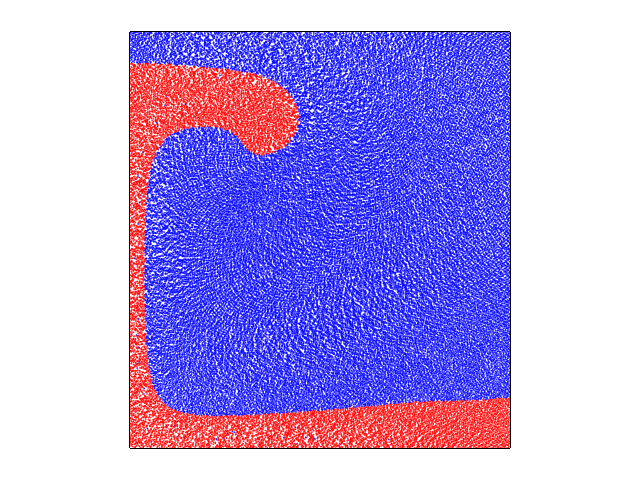

In [19]:
fig1.show()

Save RMS velocity data
====

Save time and $v_{rms}$ to file using numpy. This will create a text file with two rows in the format:

    ( time0, time1, time2 ... )
    ( vrms0, vrms1, vrms2 ... )


In [20]:
np.savetxt(outputPath+'RT_vms.out', (timevals, vrmsvals))

Check data against benchmark values
=====

Perform an analysis of the $v_{rms}$ values against time to find the maximum $v_{rms}$, the time at which this maximum occurs and the growth rate. The growth rate ($\gamma$) is calculated by solving 

$v_{rms}(t) = v_{rms}(0) \exp ( \gamma t )$

for $\gamma$ where the time chosen is half the time at maximum $v_{rms}$.

In [21]:
maxvrms = 0.0
maxtime = 0.0
maxindex = 0
index = 0
for time in timevals:
    vrms = vrmsvals[index]
    if(vrms > maxvrms):
        maxvrms = vrms
        maxtime = time
        maxindex = index
    index += 1
# calculate growth rate
vzero = vrmsvals[0]
vrms = vrmsvals[maxindex/2]
thalf = timevals[maxindex/2]
gamma = math.log(vrms/vzero)/thalf

print 'Viscosity ration = ',eta
print '     Growth rate = ',gamma
print '     t(max vrms) = ',maxtime
print '            vrms = ',maxvrms

Viscosity ration =  1.0
     Growth rate =  0.0138198014827
     t(max vrms) =  218.395978452
            vrms =  0.00313175388108


Benchmark values from van Keken *et al.* 1997 are approximately:

| Viscosity ratio ($\frac{\eta}{\eta_r}$) |  Growth rate ($\gamma$)  |  t (max $v_{rms}$) | max $v_{rms}$ |
| :-------------:  | :-----------: | :----------------: | :-----------: |
| 1.00            | 0.0112        | 208.99             | 0.0031 |
| 0.10            | 0.0459        | 71.92              | 0.0095 |
| 0.01            | 0.1042        | 49.57              | 0.0146 |

Note that these are based on high resolution and the precise values depending on the size of the time step chosen. In this example the largest timestep for the advection-diffusion solver possible is chosen. So there will be discrepancy between the values from underworld and the benchmark values.

Plot RMS velocity
=====

The commands below load the matplotlib plotting functions and plot them inside the ipython notebook cells. This will overwrite the *plt* function that was used above for the underworld plotting functions.

In [22]:
import matplotlib.pyplot as pyplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Load previous RMS velocity data
======

Load velocity and time data from a pre-run simulation for this viscosity ($\eta$) value. These were run using underworld and so should be exactly the same as those run here.

In [23]:
if(eta == 1.0):
    data = np.loadtxt(inputPath+'RT_vrms_CaseA.out')
elif(eta == 0.1):
    data = np.loadtxt(inputPath+'RT_vrms_CaseB.out')
elif(eta == 0.01):
    data = np.loadtxt(inputPath+'RT_vrms_CaseC.out')
else:
    print 'No specific data found - default to Case A'
    data = np.loadtxt(inputPath+'RT_vrms_CaseA.out')

# load them into data arrays to compare with timevals and vrmsvals from above
time_compare, vrms_compare = data[0,:], data[1,:] 
# these can be copied onto timevals and vrmsvals to skip running the time loop

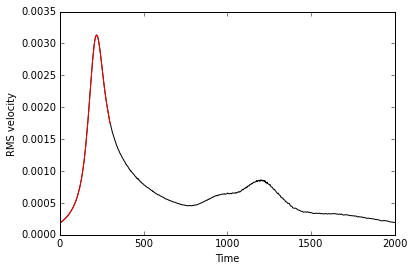

In [24]:
pyplot.plot(time_compare, vrms_compare, color = 'black') 
pyplot.plot(timevals, vrmsvals, color = 'red') 
pyplot.xlabel('Time')
pyplot.ylabel('RMS velocity')
pyplot.show()